In [2]:
library(ape)
library(tidyverse)
library(glue)

library(phytools)

library(caper)
library(lme4)
library(lmerTest)

remotes::install_github("wzmli/phyloglmm/pkg@refactor") # update this new fix: https://stackoverflow.com/questions/74961530/glmmtmb-phylo-error-in-matrixrankmatrixtmbstrucdata-tmbwhichx-length
library(glmmTMB)
 
library(phyloglmm)
library(LaplacesDemon) # documentation: https://rdrr.io/cran/phyr/man/pglmm.html

library(ggplot2)
library(ggpubr)
library(rstatix)
library(DHARMa)

Skipping install of 'phyloglmm' from a github remote, the SHA1 (8362709d) has not changed since last install.
  Use `force = TRUE` to force installation

This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')



In [3]:
# process data
do_weighted = FALSE

weighted_str = "unweighted" 
if (do_weighted)
    {
    weighted_str = "weighted" 
}

features_of_interest = c("standardized_d", "standardized_partner.diversity", "standardized_normalised.degree", "standardized_weighted.betweenness", "standardized_weighted.closeness", "standardized_hubbiness_score")

data_path <- glue("../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{weighted_str}_networks.csv")
pair_data_path = glue("../../../data/statistical_analysis/species_level/pair_data_on_{weighted_str}_networks.csv")
tree_path <- glue("../../../data/statistical_analysis/species_level/species_tree_on_{weighted_str}_networks.nwk")

unrooted_tree <- read.tree(tree_path)
tree <- multi2di(unrooted_tree)
tree <- makeNodeLabel(tree, method = "number", prefix = "Node")

data <- read.csv(data_path)
data$sample_id <- factor(data$sample_id)
data[["sample_id_numeric"]] <- as.numeric(data$sample_id)
rownames(data) <- data$sample_id

pair_data <- read.csv(pair_data_path)

# perlimiary tests for phylogenetic signal in polyploidy trait

In [3]:
# perlimiary test of association of polyploidy with phylogenetic signal
# pagel's lambda
is_polyploid <- data %>% arrange(is_polyploid) %>% pull(is_polyploid, sample_id)
is_polyploid <- as.matrix(is_polyploid[order(match(is_polyploid, tree$tip.label))])
phylosig(tree, is_polyploid, method="lambda", test=TRUE, nsim=100, se=NULL, start=NULL,
	control=list())


Phylogenetic signal lambda : 0.999934 
logL(lambda) : 7000.92 
LR(lambda=0) : 19362.1 
P-value (based on LR test) : 0 


In [4]:
# d-statistic
ctree <- di2multi(tree)
cdata <- comparative.data(phy=ctree, data=data[c("sample_id", "is_polyploid")], names.col="sample_id")
res <- phylo.d(data=cdata, phy=ctree, binvar=is_polyploid)
summary(res)


Calculation of D statistic for the phylogenetic structure of a binary variable

  Data :  data[c("sample_id", "is_polyploid")]
  Binary variable :  is_polyploid
  Counts of states:  0 = 2039
                     1 = 1678
  Phylogeny :  ctree
  Number of permutations :  1000

Estimated D :  0.1092315
Probability of E(D) resulting from no (random) phylogenetic structure :  0
Probability of E(D) resulting from Brownian phylogenetic structure    :  0



# attepmt 0: pgls without random effect

In [ ]:
cdata <- comparative.data(phy=tree, data=data[c(c("sample_id", "is_polyploid"),features_of_interest)], names.col="sample_id")

pgls_fit_d <- pgls(standardized_d ~ is_polyploid, cdata)
summary(pgls_fit_d)

pgls_fit_shanon <- pgls(standardized_partner.diversity ~ is_polyploid, cdata)
summary(pgls_fit_shanon)

pgls_fit_betweenness <- pgls(standardized_betweenness ~ is_polyploid, cdata)
summary(pgls_fit_betweenness)

pgls_fit_closeness <- pgls(standardized_closeness ~ is_polyploid, cdata)
summary(pgls_fit_closeness)

pgls_fit_degree <- pgls(standardized_normalised.degree ~ is_polyploid, cdata)
summary(pgls_fit_degree)

# attempt 2: phylogenetic glmm with random effects

In [3]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

In [4]:
data$is_polyploid = factor(data$is_polyploid)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


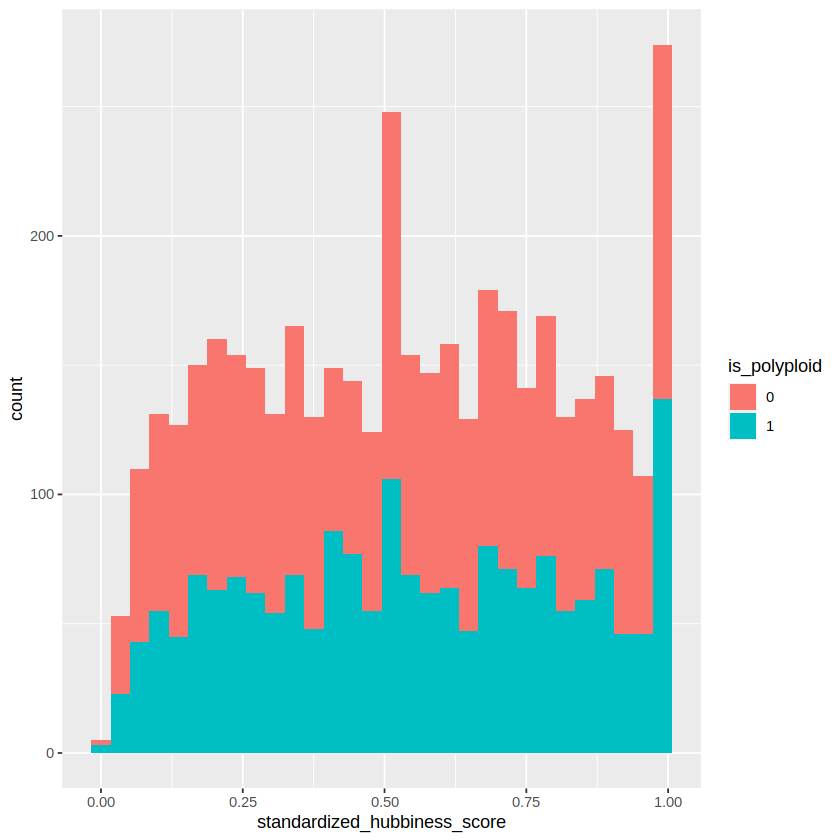

In [5]:
ggplot(data, aes(x = standardized_hubbiness_score, fill = is_polyploid)) + geom_histogram()

In [6]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_hubbiness_score~is_polyploid+(1|sample_id) +(1|network_id)+(1|num_network_plants)+(1|num_network_pollinators)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_hubbiness_score ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | num_network_plants) + (1 | num_network_pollinators)
Zero inflation:                                ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1618.0   1681.6   -799.0   1598.0     4287 

Random effects:

Conditional model:
 Groups                  Name        Variance  Std.Dev. 
 sample_id               (Intercept) 2.327e-04 1.525e-02
 network_id              (Intercept) 3.741e-11 6.116e-06
 num_network_plants      (Intercept) 2.146e-12 1.465e-06
 num_network_pollinators (Intercept) 6.214e-12 2.493e-06
Number of obs: 4297, groups:  
sample_id, 4297; network_id, 514; num_network_plants, 65; num_network_pollinators, 123

Dispersion parameter for ordbeta family (): 2.84 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.02320    0.05636  -0.412    0.681
is_polyploid1  0.03358    0.03344   1.00

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


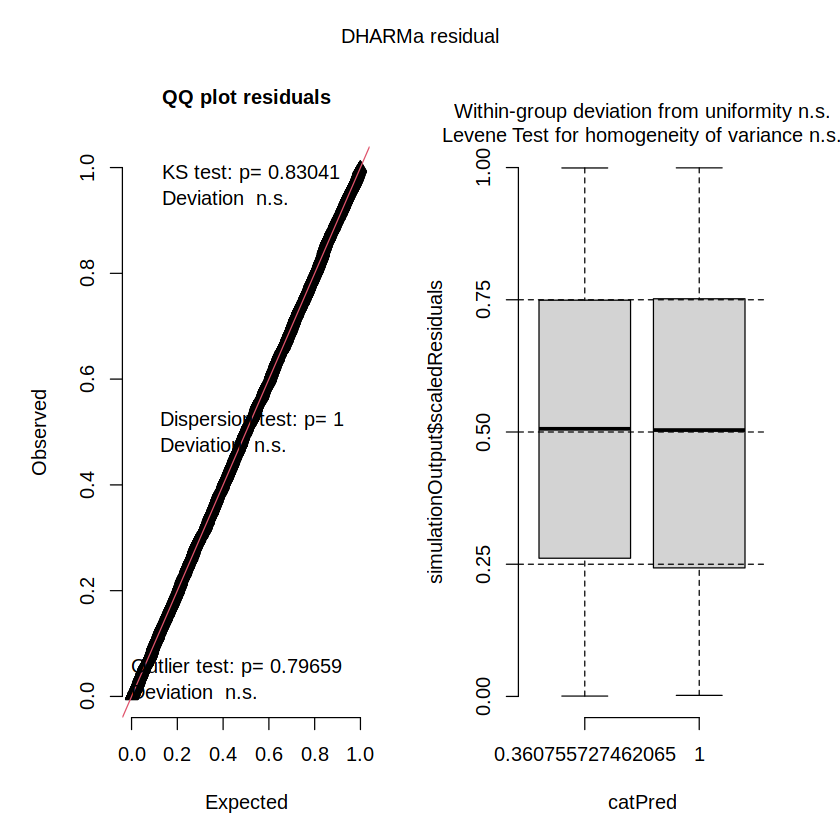

In [7]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


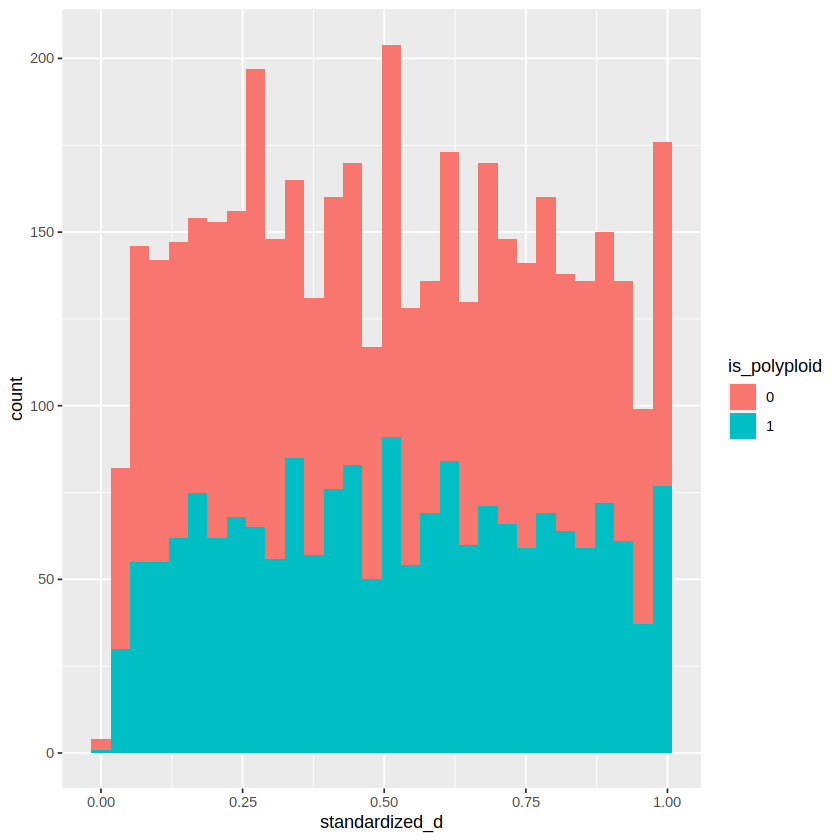

In [9]:
ggplot(data, aes(x = standardized_d, fill = is_polyploid)) + geom_histogram()

In [10]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_d~is_polyploid+(1|sample_id) +(1|network_id)+(1|num_network_plants)+(1|num_network_pollinators)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_d ~ is_polyploid + (1 | sample_id) + (1 | network_id) +  
    (1 | num_network_plants) + (1 | num_network_pollinators)
Zero inflation:                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1007.7   1071.4   -493.8    987.7     4287 

Random effects:

Conditional model:
 Groups                  Name        Variance  Std.Dev. 
 sample_id               (Intercept) 1.893e-03 4.350e-02
 network_id              (Intercept) 7.193e-12 2.682e-06
 num_network_plants      (Intercept) 3.248e-12 1.802e-06
 num_network_pollinators (Intercept) 2.648e-11 5.146e-06
Number of obs: 4297, groups:  
sample_id, 4297; network_id, 514; num_network_plants, 65; num_network_pollinators, 123

Dispersion parameter for ordbeta family (): 2.92 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.03069    0.13390   0.229    0.819
is_polyploid1  0.06303    0.03903   1.615    0.106

Zero-inflation m

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


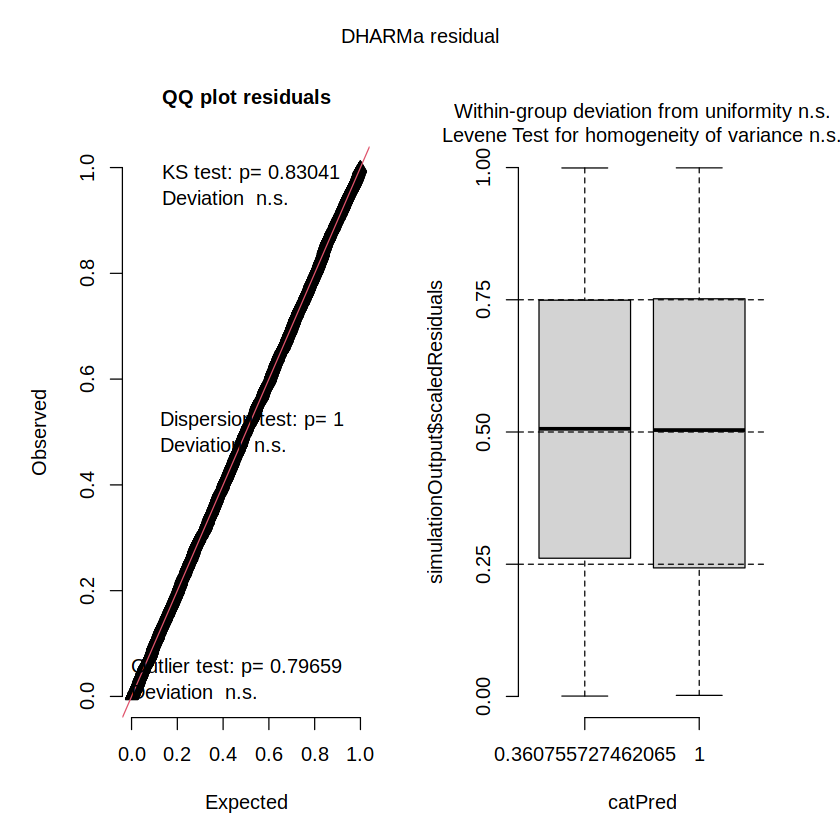

In [11]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


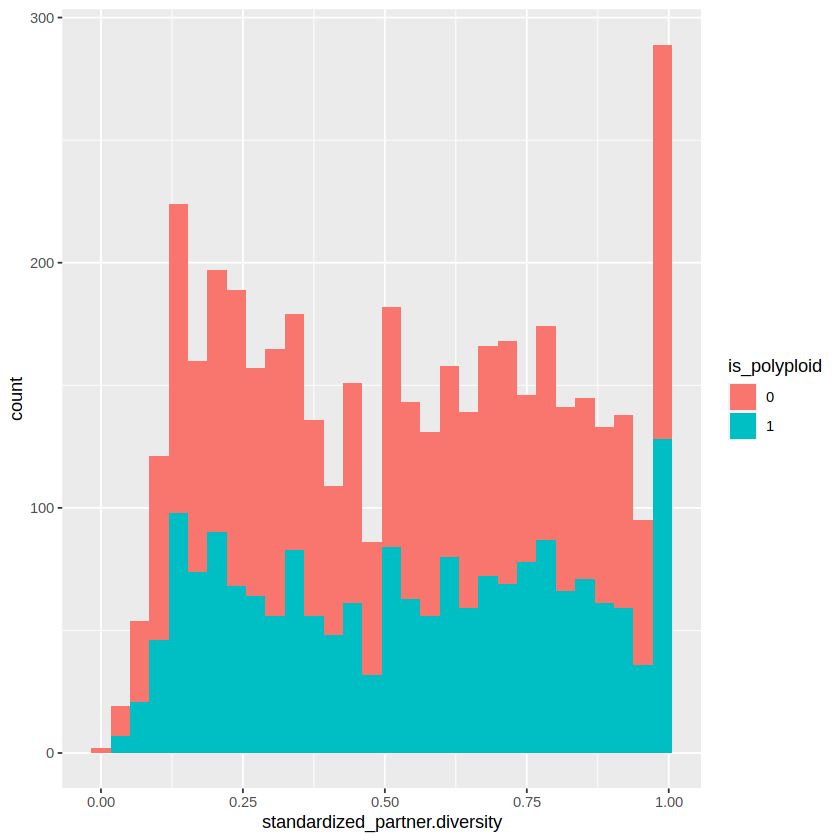

In [12]:
ggplot(data, aes(x = standardized_partner.diversity, fill = is_polyploid)) + geom_histogram()

In [13]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_partner.diversity~is_polyploid+(1|sample_id) +(1|network_id)+(1|num_network_plants)+(1|num_network_pollinators)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_partner.diversity ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | num_network_plants) + (1 | num_network_pollinators)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1174.7   1238.3   -577.3   1154.7     4287 

Random effects:

Conditional model:
 Groups                  Name        Variance  Std.Dev. 
 sample_id               (Intercept) 6.233e-03 7.895e-02
 network_id              (Intercept) 3.423e-11 5.850e-06
 num_network_plants      (Intercept) 3.474e-12 1.864e-06
 num_network_pollinators (Intercept) 2.944e-12 1.716e-06
Number of obs: 4297, groups:  
sample_id, 4297; network_id, 514; num_network_plants, 65; num_network_pollinators, 123

Dispersion parameter for ordbeta family (): 3.72 

Conditional model:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.121849   0.226739  -0.537    0.591
is_polyploid1  0.002833   0.043109

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


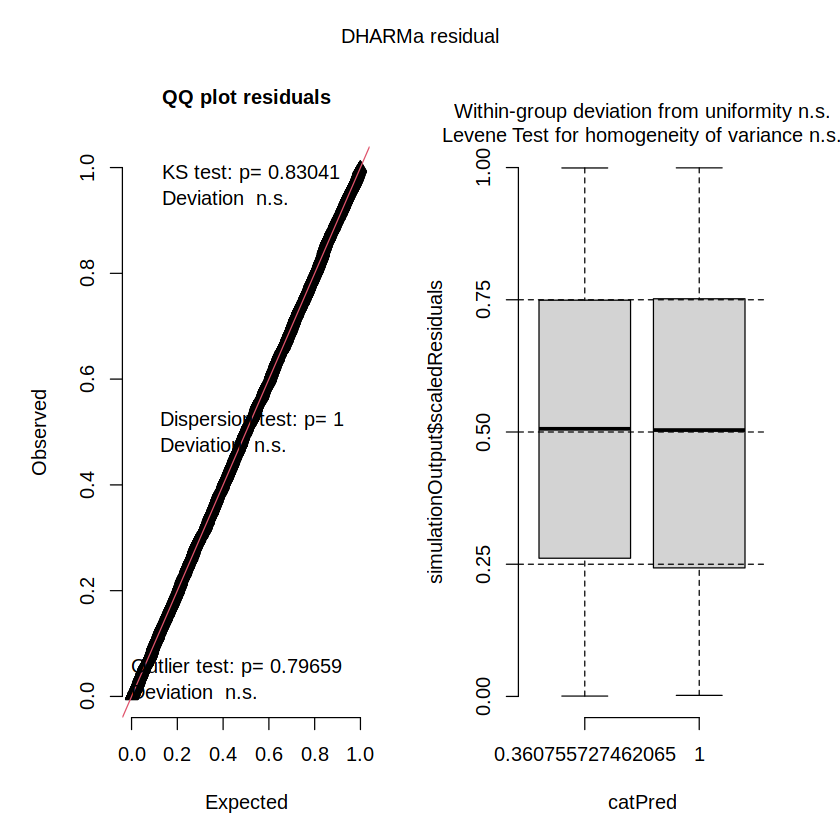

In [14]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


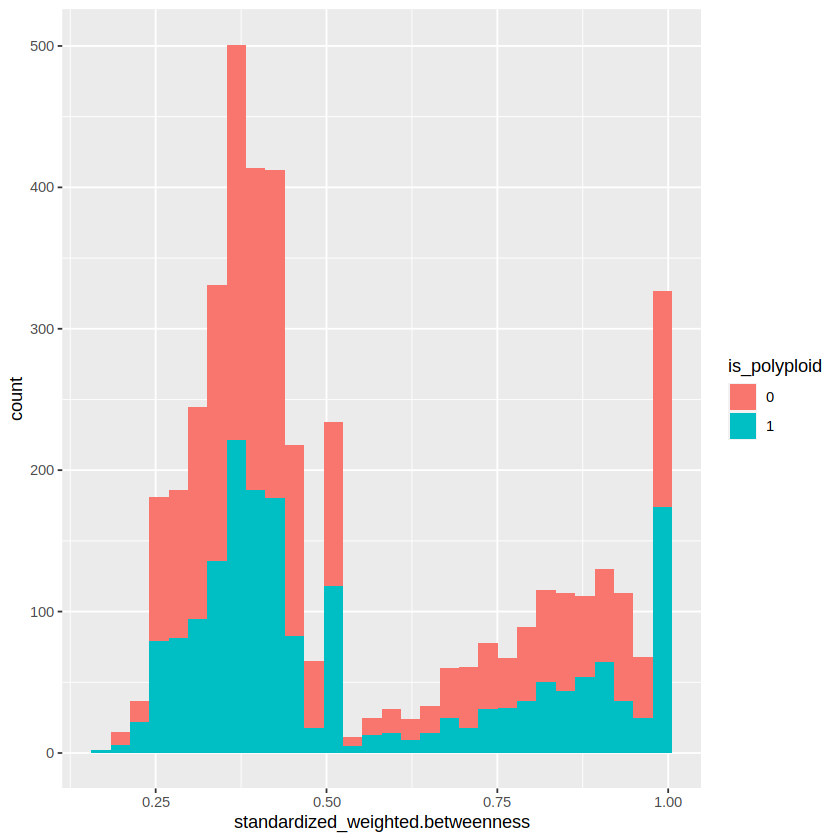

In [15]:
ggplot(data, aes(x=standardized_weighted.betweenness, fill = is_polyploid)) + geom_histogram()

In [16]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_weighted.betweenness~is_polyploid+(1|sample_id) +(1|network_id)+(1|num_network_plants)+(1|num_network_pollinators)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
summary(phylo_lmm_fit_d)

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.betweenness ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | num_network_plants) + (1 | num_network_pollinators)
Zero inflation:                                     ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
   850.6    914.3   -415.3    830.6     4287 

Random effects:

Conditional model:
 Groups                  Name        Variance  Std.Dev. 
 sample_id               (Intercept) 3.529e-03 5.940e-02
 network_id              (Intercept) 1.078e-12 1.038e-06
 num_network_plants      (Intercept) 8.784e-12 2.964e-06
 num_network_pollinators (Intercept) 1.111e-12 1.054e-06
Number of obs: 4297, groups:  
sample_id, 4297; network_id, 514; num_network_plants, 65; num_network_pollinators, 123

Dispersion parameter for ordbeta family (): 4.94 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.03273    0.17326  -0.189    0.850
is_polyploid1 -0.03546    0.03

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


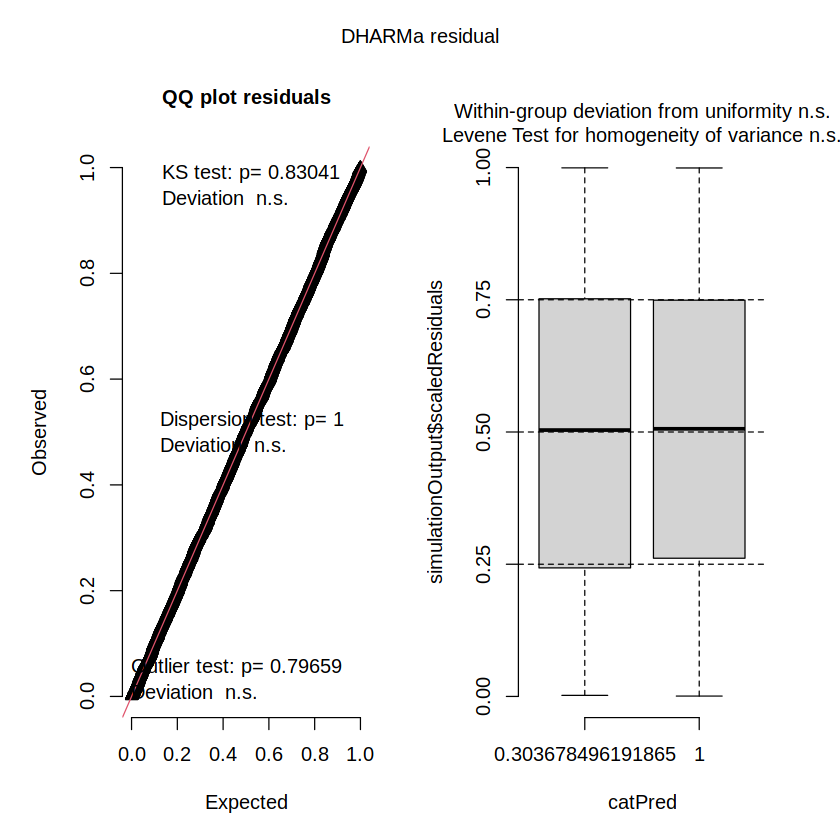

In [17]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


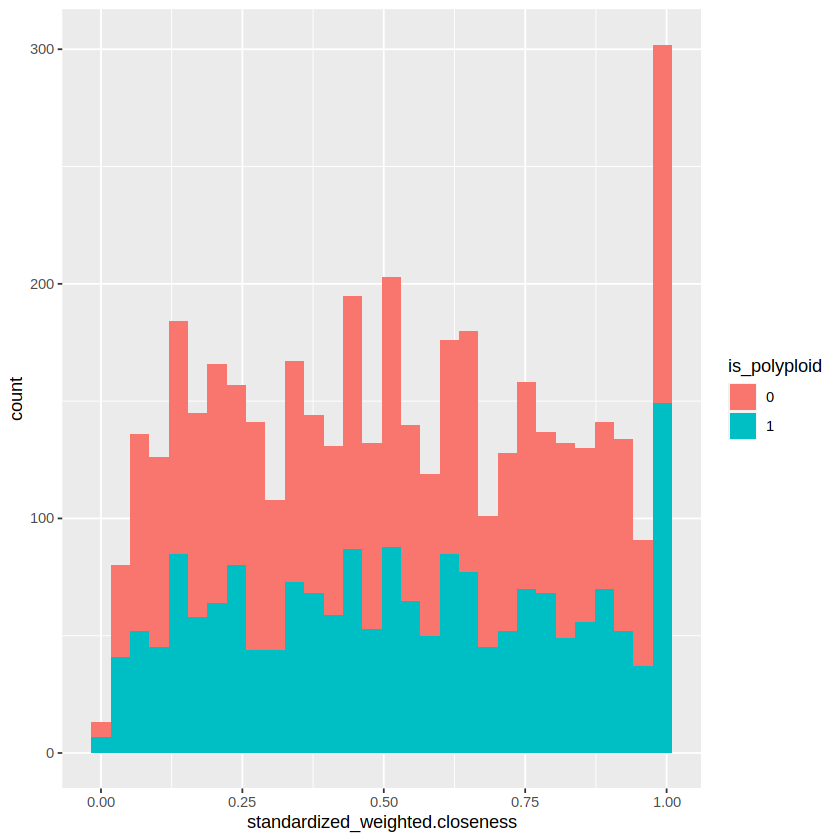

In [18]:
ggplot(data, aes(x=standardized_weighted.closeness, fill = is_polyploid)) + geom_histogram()

In [19]:
phylo_lmm_fit_d <- phylo_glmmTMB(formula=standardized_weighted.closeness~is_polyploid+(1|sample_id) +(1|network_id)+(1|num_network_plants)+(1|num_network_pollinators)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"), #lmerControl(check.nobs.vs.nlev="ignore",check.nobs.vs.nRE="ignore")
)
summary(phylo_lmm_fit_d)

Warning message in glmmTMB::fitTMB(TMBStruc):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting')”


 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.closeness ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | num_network_plants) + (1 | num_network_pollinators)
Zero inflation:                                   ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1613.2   1676.9   -796.6   1593.2     4287 

Random effects:

Conditional model:
 Groups                  Name        Variance  Std.Dev. 
 sample_id               (Intercept) 4.316e-03 6.569e-02
 network_id              (Intercept) 3.742e-11 6.117e-06
 num_network_plants      (Intercept) 4.531e-13 6.731e-07
 num_network_pollinators (Intercept) 6.266e-12 2.503e-06
Number of obs: 4297, groups:  
sample_id, 4297; network_id, 514; num_network_plants, 65; num_network_pollinators, 123

Dispersion parameter for ordbeta family ():  3.1 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.17437    0.19289  -0.904    0.366
is_polyploid1 -0.03112    0.04261 

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


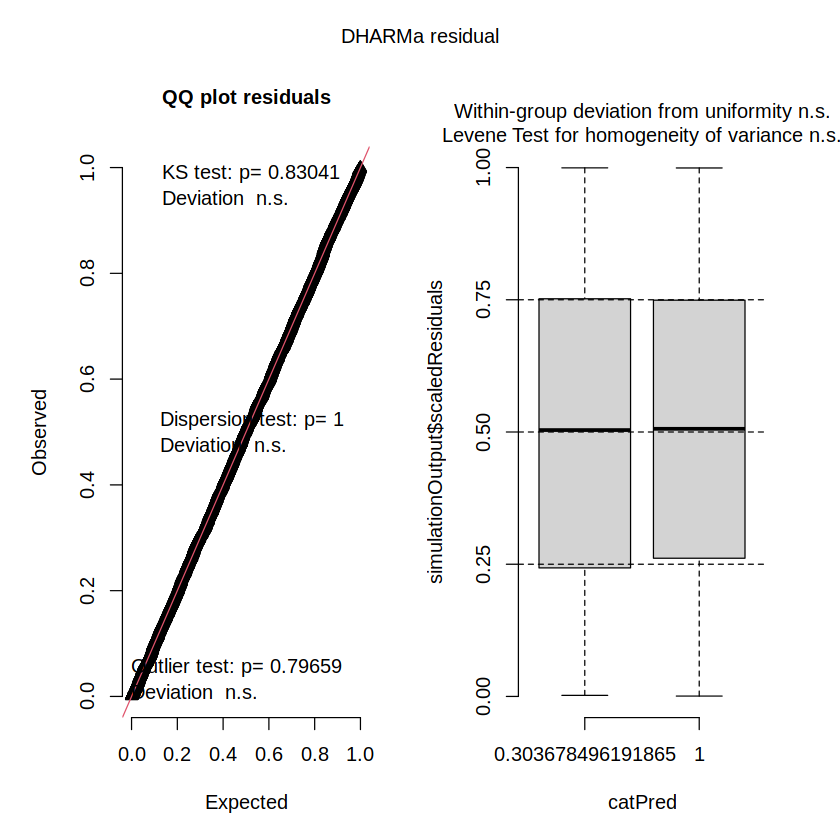

In [20]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


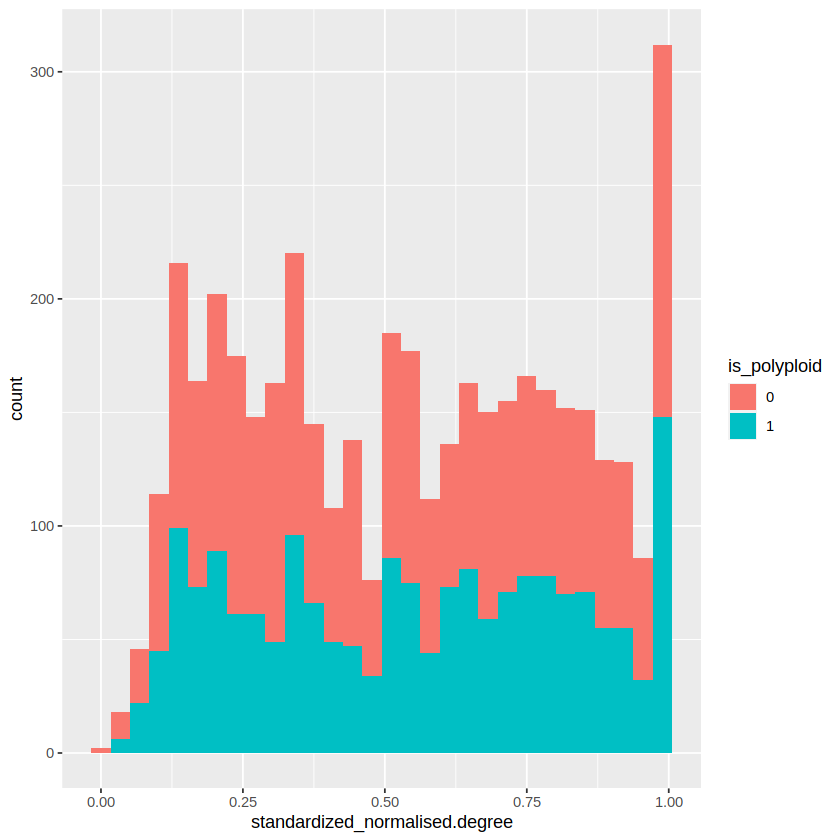

In [21]:
ggplot(data, aes(x=standardized_normalised.degree, fill = is_polyploid)) + geom_histogram()

In [22]:
phylo_lmm_fit_degree <- phylo_glmmTMB(formula=standardized_normalised.degree~is_polyploid+(1|sample_id) +(1|network_id)+(1|num_network_plants)+(1|num_network_pollinators)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"), #lmerControl(check.nobs.vs.nlev="ignore",check.nobs.vs.nRE="ignore")
)
summary(phylo_lmm_fit_degree)

 Family: ordbeta  ( logit )
Formula:          
standardized_normalised.degree ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | num_network_plants) + (1 | num_network_pollinators)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1235.8   1299.5   -607.9   1215.8     4287 

Random effects:

Conditional model:
 Groups                  Name        Variance  Std.Dev. 
 sample_id               (Intercept) 7.190e-03 8.480e-02
 network_id              (Intercept) 1.420e-11 3.768e-06
 num_network_plants      (Intercept) 1.768e-10 1.330e-05
 num_network_pollinators (Intercept) 3.335e-13 5.775e-07
Number of obs: 4297, groups:  
sample_id, 4297; network_id, 514; num_network_plants, 65; num_network_pollinators, 123

Dispersion parameter for ordbeta family (): 3.86 

Conditional model:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.1298867  0.2419380  -0.537    0.591
is_polyploid1  0.0007033  0.0437

Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


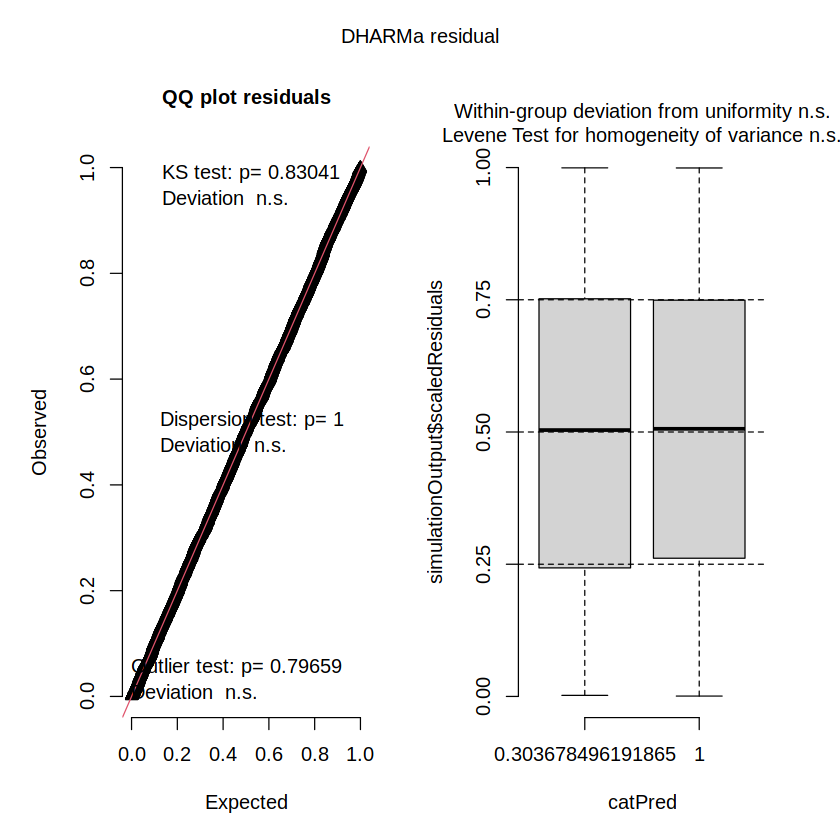

In [23]:
res = simulateResiduals(phylo_lmm_fit_d)
plot(res, asFactor = T)

# perform test on poly-diplo pairs

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


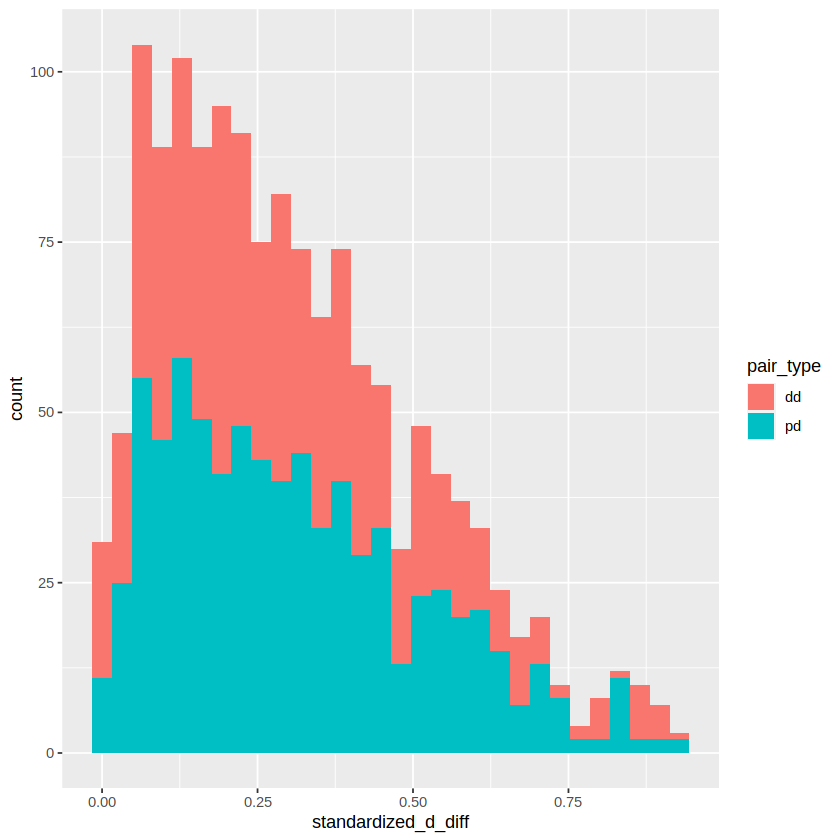

In [25]:
ggplot(pair_data, aes(x=standardized_d_diff, fill = pair_type)) + geom_histogram()

In [26]:
mixed = glmmTMB(formula=standardized_d_diff~pair_type+(1|pair)+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_d_diff ~ pair_type + (1 | pair) + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -634.5   -597.6    324.2   -648.5     1425 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 pair              (Intercept) 0.011287 0.10624 
 network_id        (Intercept) 0.012790 0.11309 
 phylogenetic_dist (Intercept) 0.004468 0.06684 
Number of obs: 1432, groups:  
pair, 734; network_id, 289; phylogenetic_dist, 599

Dispersion parameter for beta family (): 4.65 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.79324    0.03802 -20.863   <2e-16 ***
pair_typepd  0.03009    0.04994   0.603    0.547    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.2570     

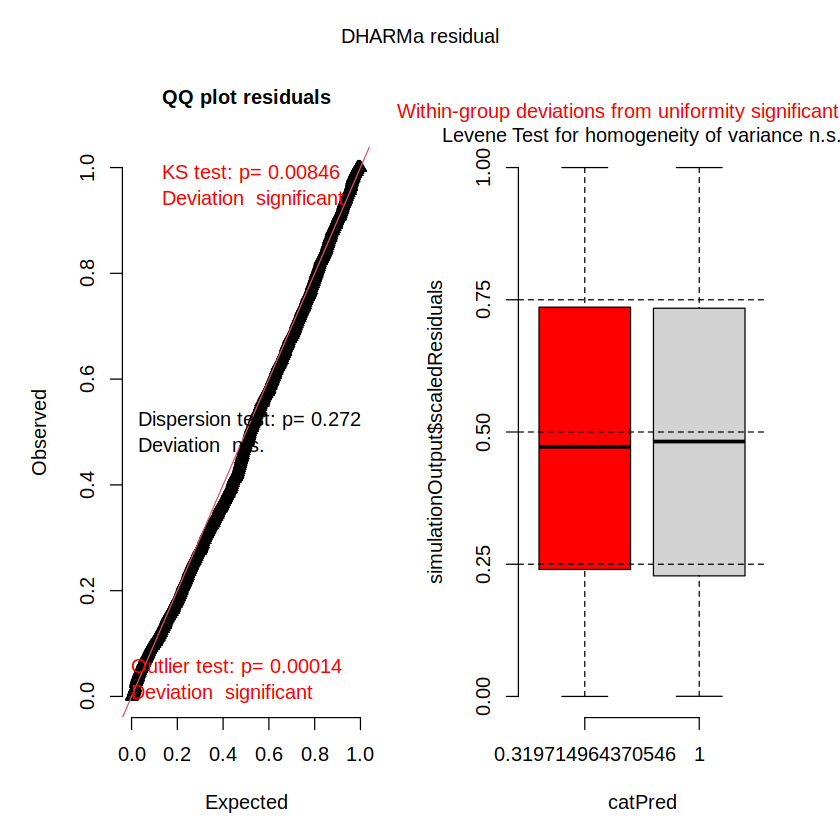

In [27]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


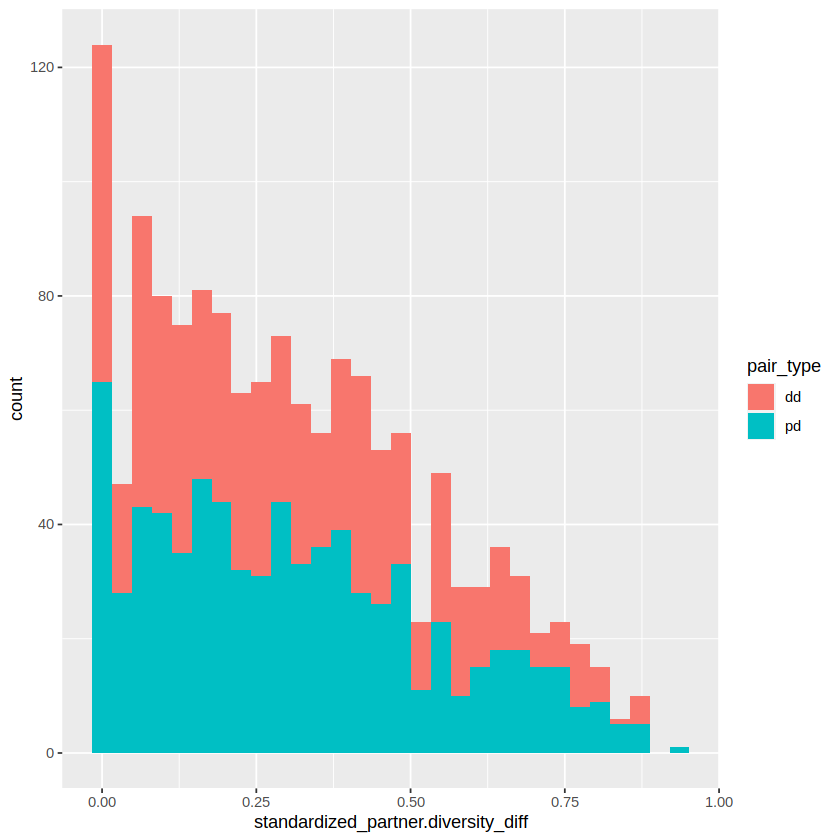

In [28]:
ggplot(pair_data, aes(x=standardized_partner.diversity_diff, fill = pair_type)) + geom_histogram()

In [29]:
mixed = glmmTMB(formula=standardized_partner.diversity_diff~pair_type+(1|pair)+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_partner.diversity_diff ~ pair_type + (1 | pair) +  
    (1 | network_id) + (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   119.2    156.1    -52.6    105.2     1425 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 pair              (Intercept) 0.09873  0.3142  
 network_id        (Intercept) 0.05724  0.2393  
 phylogenetic_dist (Intercept) 0.01850  0.1360  
Number of obs: 1432, groups:  
pair, 734; network_id, 289; phylogenetic_dist, 599

Dispersion parameter for beta family (): 5.16 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.66374    0.04770 -13.916   <2e-16 ***
pair_typepd  0.01457    0.05881   0.248    0.804    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z

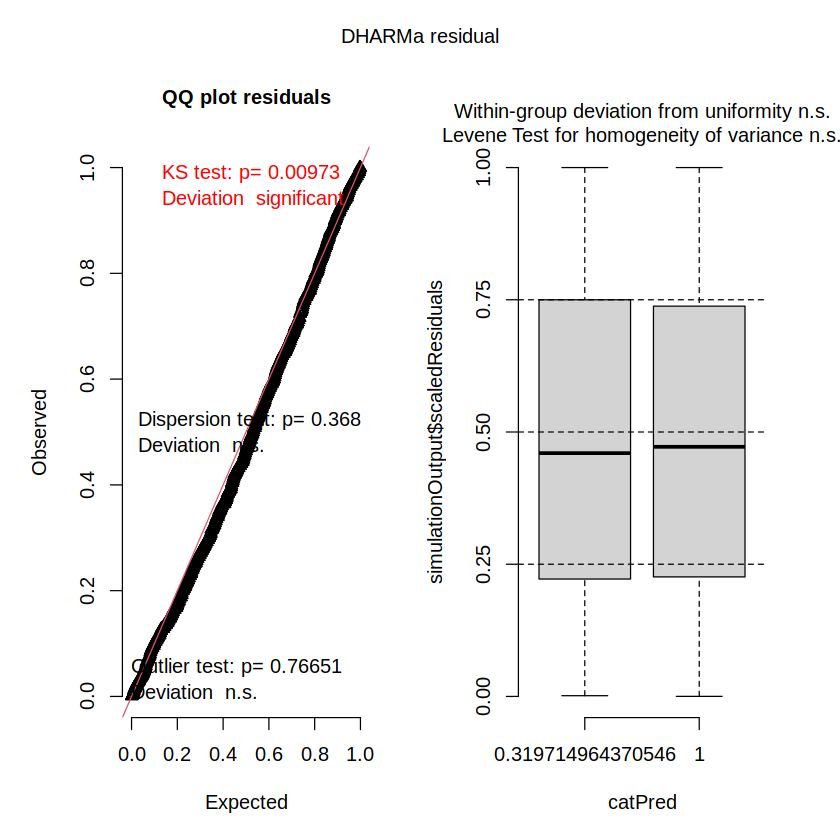

In [30]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


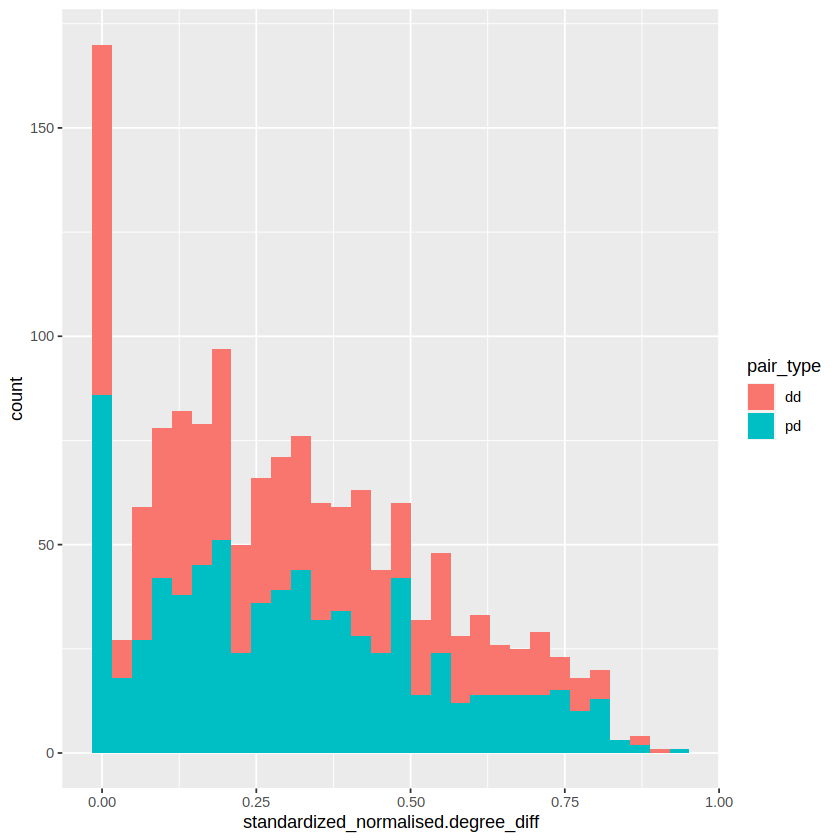

In [31]:
ggplot(pair_data, aes(x=standardized_normalised.degree_diff, fill = pair_type)) + geom_histogram()

In [32]:
mixed = glmmTMB(formula=standardized_normalised.degree_diff~pair_type+(1|pair)+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_normalised.degree_diff ~ pair_type + (1 | pair) +  
    (1 | network_id) + (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   348.8    385.7   -167.4    334.8     1425 

Random effects:

Conditional model:
 Groups            Name        Variance  Std.Dev. 
 pair              (Intercept) 1.125e-01 3.354e-01
 network_id        (Intercept) 6.105e-02 2.471e-01
 phylogenetic_dist (Intercept) 7.946e-10 2.819e-05
Number of obs: 1432, groups:  
pair, 734; network_id, 289; phylogenetic_dist, 599

Dispersion parameter for beta family ():    6 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.61806    0.04666 -13.246   <2e-16 ***
pair_typepd  0.04711    0.05690   0.828    0.408    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z valu

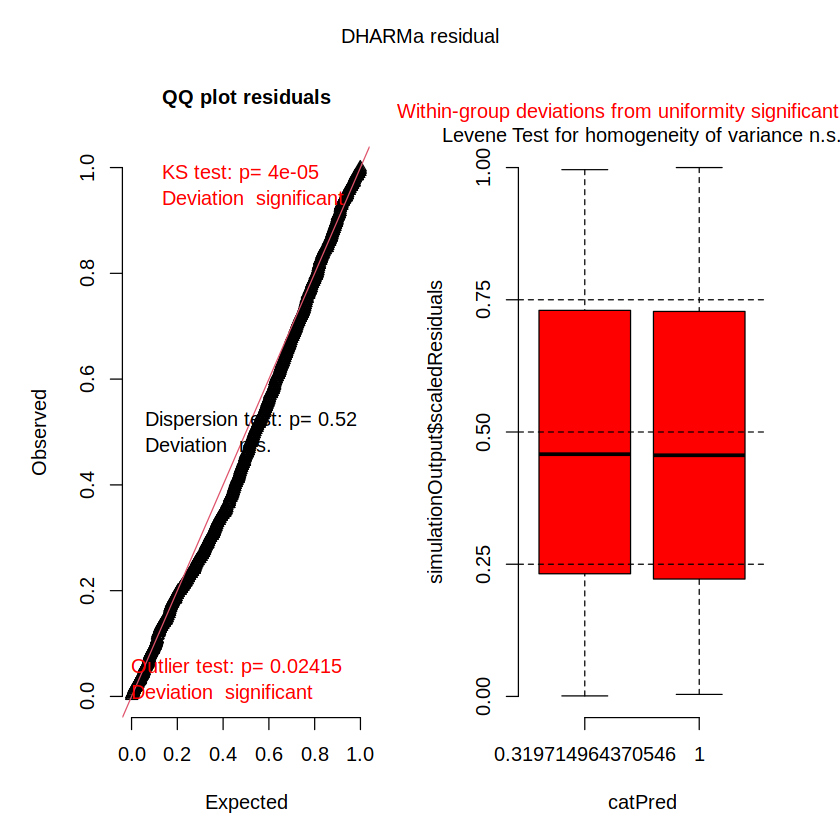

In [33]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


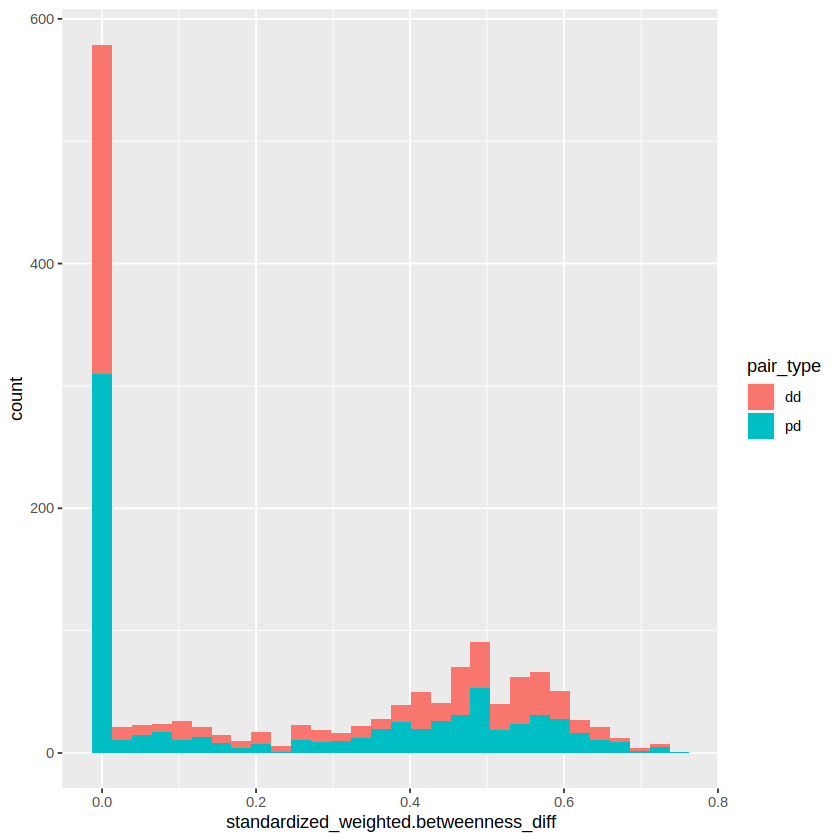

In [34]:
ggplot(pair_data, aes(x=standardized_weighted.betweenness_diff, fill = pair_type)) + geom_histogram()

In [35]:
mixed = glmmTMB(formula=standardized_weighted.betweenness_diff~pair_type+(1|pair)+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.betweenness_diff ~ pair_type + (1 | pair) +  
    (1 | network_id) + (1 | phylogenetic_dist)
Zero inflation:                                          ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  1424.4   1461.2   -705.2   1410.4     1425 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 pair              (Intercept) 0.17371  0.4168  
 network_id        (Intercept) 0.04101  0.2025  
 phylogenetic_dist (Intercept) 0.03408  0.1846  
Number of obs: 1432, groups:  
pair, 734; network_id, 289; phylogenetic_dist, 599

Dispersion parameter for beta family (): 8.39 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.36986    0.05383  -6.871 6.36e-12 ***
pair_typepd -0.01426    0.06913  -0.206    0.837    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value 

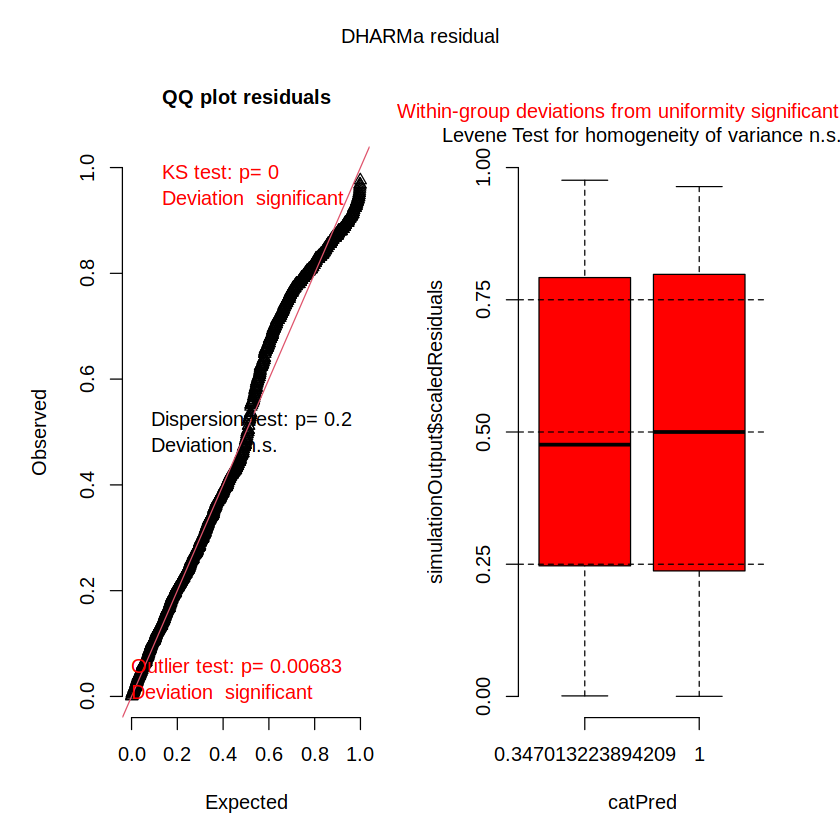

In [36]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


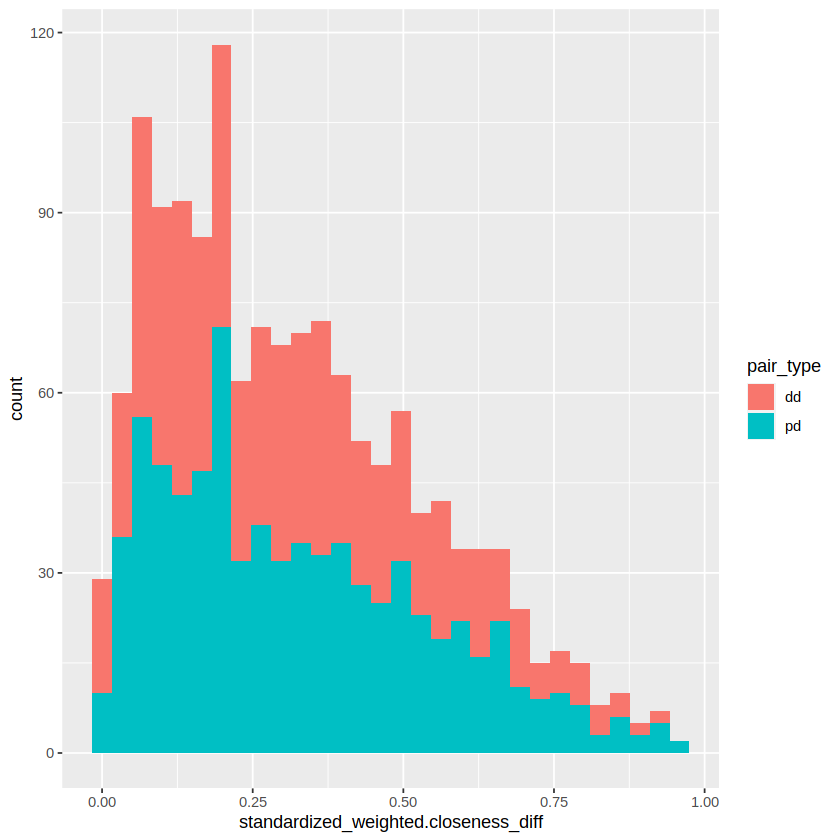

In [37]:
ggplot(pair_data, aes(x=standardized_weighted.closeness_diff, fill = pair_type)) + geom_histogram()

In [38]:
mixed = glmmTMB(formula=standardized_weighted.closeness_diff~pair_type+(1|pair)+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.closeness_diff ~ pair_type + (1 | pair) +  
    (1 | network_id) + (1 | phylogenetic_dist)
Zero inflation:                                        ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -510.9   -474.1    262.5   -524.9     1425 

Random effects:

Conditional model:
 Groups            Name        Variance  Std.Dev. 
 pair              (Intercept) 1.617e-01 4.022e-01
 network_id        (Intercept) 1.002e-02 1.001e-01
 phylogenetic_dist (Intercept) 3.620e-09 6.017e-05
Number of obs: 1432, groups:  
pair, 734; network_id, 289; phylogenetic_dist, 599

Dispersion parameter for beta family (): 4.95 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.75923    0.04409  -17.22   <2e-16 ***
pair_typepd  0.04710    0.05888    0.80    0.424    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z va

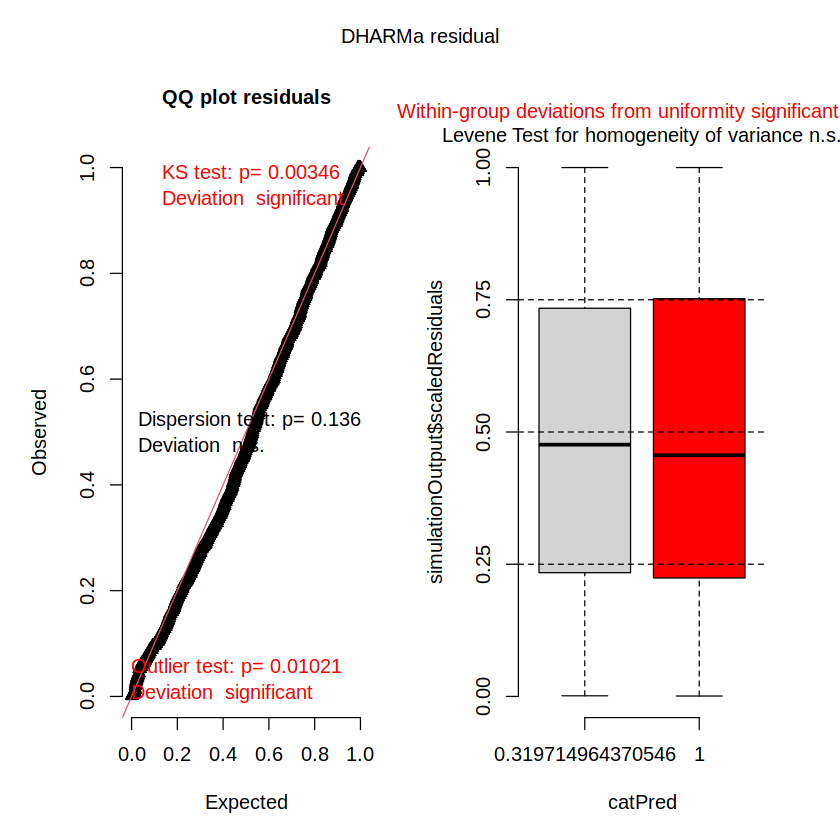

In [39]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


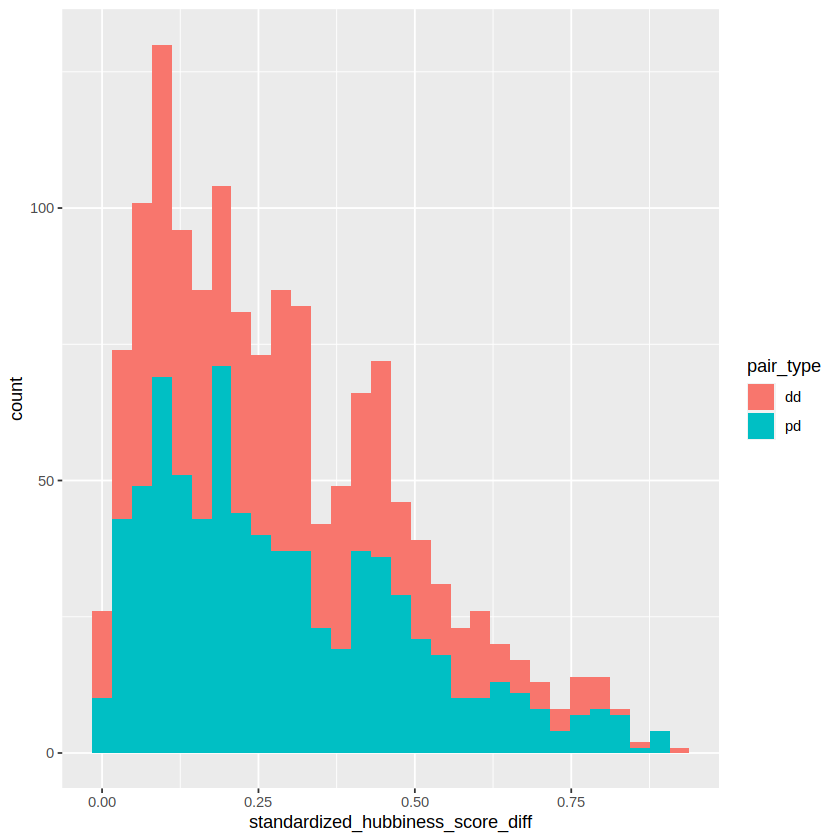

In [40]:
ggplot(pair_data, aes(x=standardized_hubbiness_score_diff, fill = pair_type)) + geom_histogram()


In [41]:
mixed = glmmTMB(formula=standardized_hubbiness_score_diff~pair_type+(1|pair)+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          standardized_hubbiness_score_diff ~ pair_type + (1 | pair) +  
    (1 | network_id) + (1 | phylogenetic_dist)
Zero inflation:                                     ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -796.1   -759.2    405.1   -810.1     1425 

Random effects:

Conditional model:
 Groups            Name        Variance  Std.Dev. 
 pair              (Intercept) 7.514e-02 2.741e-01
 network_id        (Intercept) 2.940e-03 5.422e-02
 phylogenetic_dist (Intercept) 2.492e-09 4.992e-05
Number of obs: 1432, groups:  
pair, 734; network_id, 289; phylogenetic_dist, 599

Dispersion parameter for beta family (): 5.17 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.90439    0.03943 -22.934   <2e-16 ***
pair_typepd  0.03716    0.05290   0.702    0.482    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(

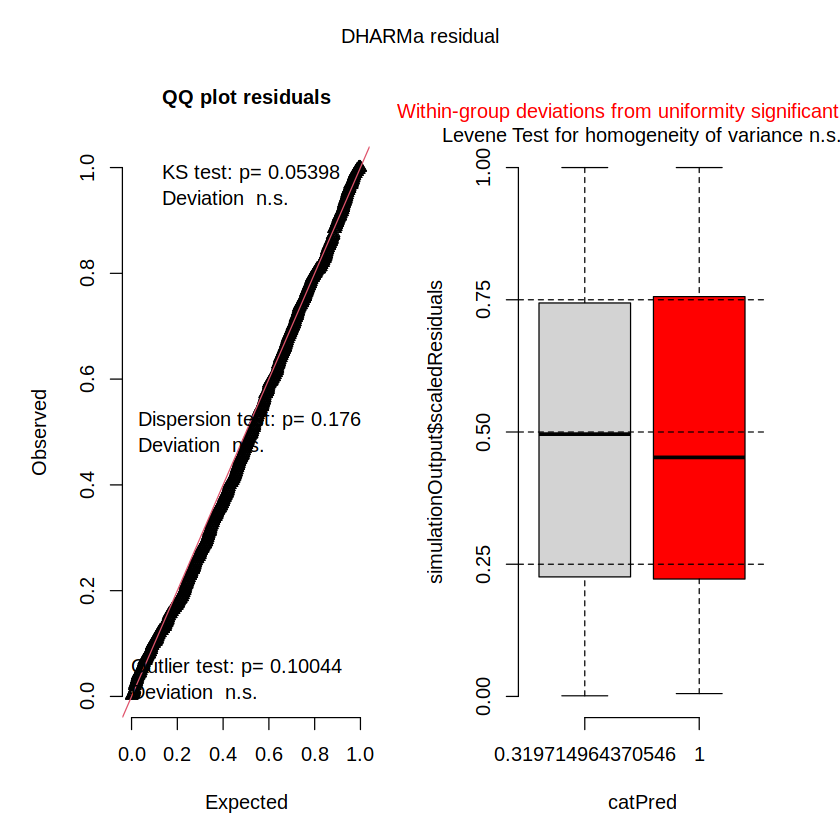

In [42]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

# compute niche overlap across pairs

In [43]:
source("../../../code/feature_computation/utils.R")
library(pbmcapply)
library(vegan)

Loading required package: vegan

Loading required package: permute


Attaching package: ‘permute’


The following object is masked from ‘package:LaplacesDemon’:

    Blocks


Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘vegan’


The following object is masked from ‘package:phytools’:

    scores


Loading required package: sna

Loading required package: statnet.common


Attaching package: ‘statnet.common’


The following objects are masked from ‘package:base’:

    attr, order


Loading required package: network


‘network’ 1.17.1 (2021-06-12), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


sna: Tools for Social Network Analysis
Version 2.7 created on 2022-05-09.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
 For citation information, type citation("sna").
 Type help(package="sn

In [44]:
get_niche_overlap <-function(network_path, member1, member2)
    {
    network = process_network(network_path)
    res = as.matrix(vegdist(network, method="horn"))
    if (!((member1 %in% rownames(res) && (member2 %in% rownames(res)))))
        {
        return(NA)
        }
    return(res[c(member1),c(member2)])  
    }

In [55]:
pair_data["horn_index"] = pbmcmapply(get_niche_overlap, 
                                     pair_data$network_path, 
                                     pair_data$member1, 
                                     pair_data$member2,
                                     ignore.interactive = getOption("ignore.interactive", T),
                                     mc.cores = 10)

  |=======================================================| 100%, Elapsed 01:57


In [56]:
write.csv(pair_data, pair_data_path)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 287 rows containing non-finite values (`stat_bin()`).”


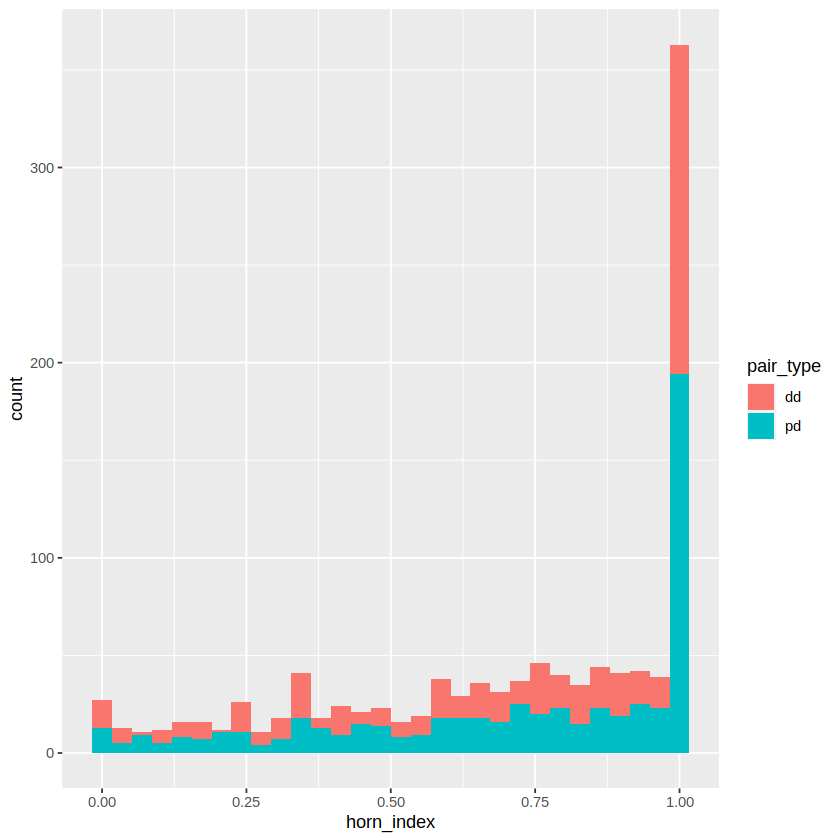

In [57]:
ggplot(pair_data, aes(x=horn_index, fill = pair_type)) + geom_histogram()

In [80]:
# error https://github.com/glmmTMB/glmmTMB/issues/744
theta_pos <- 1
theta_value <- c(1e3, 1e3, 1e3)

mixed = glmmTMB(formula=horn_index~pair_type+(1|pair)+(1|network_id)+(1|phylogenetic_dist), 
                , family=ordbeta(link = "logit")
                , ziformula=~0
                , data=pair_data[!is.na(pair_data$horn_index), ]
                , control= glmmTMBControl(rank_check = "skip"))
                # , start = list(theta = log(theta_value)),
                # , map = list(theta = factor(c(NA, NA, NA))))
print(summary(mixed))

ERROR: Error in fitTMB(TMBStruc): negative log-likelihood is NaN at starting parameter values


In [ ]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)